In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm
from design import BaseDesign
from spectrum import BaseSpectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from typing import Sequence



In [2]:



edge_filter = False
back_reflector_full_gap = False
back_reflector = True

if edge_filter:
    films_rep, losses_rep, best_film_rep = load('./raw_result/edge_filter_design_result')
    def rm_last_rep(xs):
        for x in xs:
            x: list
            x.pop()
    design = make_edgefilter_design()
    rm_last_rep([films_rep, losses_rep, best_film_rep])
elif back_reflector_full_gap:
    films_rep, losses_rep, best_film_rep = load('./raw_result/back_reflector_result')
    design = make_reflection_design(wls=np.linspace(695, 939, 500))
elif back_reflector:
    losses_rep, best_film_rep, design = load('./raw_result/reflector_minwl_600_maxwl_800_batch_size_200_alpha_0.1_n_min1.5_n_max3')
    design = make_reflection_design(wls=np.linspace(600, 800, 500))

rep = 0
ot_id = 0
iter_id = -1
f = best_film_rep[rep][ot_id]
# f = best_film_rep[rep][ot_id]

film has no spec. use 1000 nm


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.002585344395377933


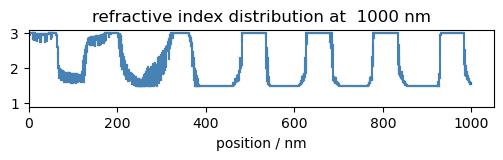

In [3]:

ax, fig = plot_layer_thickness(f)


print(calculate_RMS_f_spec(f, design.target_specs))

def plot_training(losses):
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(len(losses)), losses)
    ax.set_xlabel('step')
    ax.set_ylabel('loss')
    ax.set_yscale('log')



Show slice

In [ ]:
def loss_slice(f: FreeFormFilm, 
               target_specs: Sequence[BaseSpectrum], 
               n_min, 
               n_max, 
               layers_var=None
            ):
    assert 0 <= layers_var[0] <= layers_var[-1] < f.get_layer_number()
    if layers_var is None:
        layers_var = np.arange(f.get_layer_number())

    work_film = copy.deepcopy(f)
    resolution = 20
    n_var = np.linspace(n_min, n_max, resolution)
    
    img = np.zeros((resolution, layers_var.shape[0]))

    for i in range(layers_var.shape[0]):
        
        # print(i / layers_var.shape[0])
        for j in range(resolution):
            n = f.get_n().copy()
            n[layers_var[i]] = n_var[j]
            work_film.update_n(n)
            img[j, i] = calculate_RMS_f_spec(work_film, target_specs)
    return img

def show_slice(img):
    fig, ax = plt.subplots(1, 1)
    s = ax.imshow(
        img, 
        cmap='viridis', 
        aspect='auto', 
        interpolation=None, 
        extent=[layers_var[0], layers_var[-1], n_max, n_min], 
        # vmax=0.05
    )
    ax.set_xlabel('layer index')
    ax.set_ylabel('n')
    ax.invert_yaxis()
    cbar = fig.colorbar(s)
    cbar.set_label('loss')


layers_var = np.arange(450, 500, 1)
n_min = 1
n_max = 10
img = loss_slice(f, design.target_specs, n_min, n_max, layers_var=layers_var)

show_slice(img)

plot_layer_thickness(FreeFormFilm(f.get_n()[layers_var], f.get_d()[layers_var].sum(), 'SiO2'))


Show projection

In [4]:
def loss_projection(
	f: FreeFormFilm, 
	target_specs: Sequence[BaseSpectrum], 
	n_min, 
	n_max, 
	i1, 
	i2
):

	work_film = copy.deepcopy(f)
	resolution = 20
	n_var = np.linspace(n_min, n_max, resolution)

	img = np.zeros((resolution, resolution))

	for i in range(resolution):
		# print(i / resolution)

		for j in range(resolution):
			n = f.get_n().copy()
			n[i1] = n_var[i]
			n[i2] = n_var[j]
			work_film.update_n(n)
			img[j, i] = calculate_RMS_f_spec(work_film, target_specs)
	return img


def show_projection(img):
	
    fig, ax = plt.subplots(1, 1)
    s = ax.contourf(
        img, 
        cmap='viridis', 
        aspect='auto', 
        interpolation=None, 
        extent=[n_min, n_max, n_min, n_max], 
        # vmax=1
    )
    ax.set_xlabel('$n_1$')
    ax.set_ylabel('$n_2$')
    # ax.invert_yaxis()
    cbar = fig.colorbar(s)
    cbar.set_label('loss')

    n_c_min = 1
    n_c_max = 3
    n_c_best = n_c_min

    ax.plot([n_c_min, n_c_max], [n_c_min, n_c_min], label='constraint', c='C0')
    ax.plot([n_c_min, n_c_max], [n_c_max, n_c_max], c='C0')
    ax.plot([n_c_min, n_c_min], [n_c_min, n_c_max], c='C0')
    ax.plot([n_c_max, n_c_max], [n_c_min, n_c_max], c='C0')
    # ax.scatter(n_c_best, n_c_best - 0.1, marker='$*$', s=200, c='C3', zorder=3)
    # ax.scatter(n_c_best, n_c_best, marker='*', s=100, c='C3', zorder=3)

    return fig, ax    



(1.7221023575815186+0j)


In [27]:

i1_start = 1665
i1_right = 10

for i1 in range(i1_start, i1_start + i1_right, 1):
    i2 = i1 + 1
    n_min = 0.1
    n_max = 10
    img = loss_projection(f, design.target_specs, n_min, n_max, i2, i2 + 1)

    fig, ax = show_projection(img)
    thickness_dif = (i2 - i1) * f.get_d().sum() / f.get_layer_number()
    ax.set_title(f'position 1: {f.get_d()[:i1].sum(): .2f}, position 2: {f.get_d()[:i2].sum(): .2f}')

    # fig.savefig(f'./results/sparsity-loss_landscape/landscape_projection_thickness_dif_{thickness_dif: .4f}.png', dpi=300)

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_13008\1006472256.py:31: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  s = ax.contourf(


film has no spec. use 1000 nm


(<AxesSubplot: title={'center': 'refractive index distribution at  1000 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

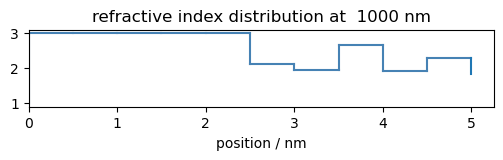

In [24]:
i1 = 1665
i_inc = 10
plot_layer_thickness(FreeFormFilm(f.get_n()[i1: i1 + i_inc], f.get_d()[i1: i1 + i_inc].sum(), f.get_n()[i1 + i_inc].real))